# Rectangular Packing with Reinforcement Learning

## Initiate Environment

In [2]:
# load package
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [3]:
data = pd.read_csv('Minh_cute_train.csv')
data

,Width,Height,Quantity
0,17,9,1
1,12,9,1
2,16,9,1
3,11,9,1
4,1,9,1
...,...,...,...
77,14,8,1
78,16,3,1
79,9,15,1
80,9,7,1


### Environment for RP algorithm


In [4]:
class Packing:
    def __init__(self, width, height, items):
        # Initialize the environment 
        self.width = width
        self.height = height
        self.items = items
        self.num_items = len(items)

        # Initialize the frame
        self.frame = torch.zeros((self.height, self.width), requires_grad=False)  
        self.empty_positions = [(0, 100)]
        self.placed_items = []
        self.remain_items = []

        self.reset()

    def reset(self):
        # Reset the environment
        with torch.no_grad():
            self.frame.zero_()  # reset zero for all cell in frame
        self.placed_items = [] # the list which contains the placed items
        self.remain_items = [list(item) for item in self.items] # the remain items in stock
        self.empty_positions = [(0, 0)] # the empty positions in frame

    def can_place(self, x, y, h, w):
        # check condition to place the item
        if x + h > self.height or y + w > self.width:
            return False
        return torch.all(self.frame[x:x + h, y:y + w] == 0) 

    def update_empty_positions(self, x, y, h, w):
        new_positions = []
        if y + w < self.width:
            new_positions.append((x, y + w))
        if x + h < self.height:
            new_positions.append((x + h, y))

        self.empty_positions = [
            pos for pos in self.empty_positions
            if not (x <= pos[0] < x + h and y <= pos[1] < y + w)
        ]
        self.empty_positions.extend(new_positions)

    def place(self, action):
        index, rotated = action
        if self.remain_items[index] == [0, 0]:
            return False, -5 

        h, w = self.remain_items[index]
        if rotated:
            h, w = w, h

        max_possible_adjacency = 2 * (h + w)
        max_penalty = self.width * self.height

        best_position = None
        best_reward = -float('inf')

        for x, y in self.empty_positions:
            if self.can_place(x, y, h, w):
                # calculate reward elements
                adjacency_bonus = self.calc_adjacency(x, y, h, w) / max_possible_adjacency
                square_bonus = self.calc_square_bonus(h, w)
                space_penalty = self.calc_space_penalty(x, y, h, w) / max_penalty

                remaining_space = (self.width * self.height - torch.sum(self.frame).item())
                ratio_s = (h * w) / remaining_space if remaining_space > 0 else 0

                reward = (
                        ratio_s * 0.7 
                        + adjacency_bonus * 0.2
                        + square_bonus * 0.1
                        - space_penalty * 0.1
                )

                #penalty if not square or adjency 
                if square_bonus < 0.5 and adjacency_bonus < 0.3:
                    reward -= 0.2
                
                #update best reward 
                if reward > best_reward:
                    best_reward = reward
                    best_position = (x, y)

        #place item
        if best_position:
            x, y = best_position
            with torch.no_grad():
                self.frame[x:x + h, y:y + w] = 1
            self.remain_items[index] = [0, 0]
            self.placed_items.append((index, x, y, h, w, rotated))
            self.update_empty_positions(x, y, h, w)
            return True, best_reward

        return False, -5

    # function to calculate the adjacency bonus
    def calc_adjacency(self, x, y, h, w):
        bonus = 0
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in directions:
            for i in range(h):
                for j in range(w):
                    nx, ny = x + i + dx, y + j + dy
                    if 0 <= nx < self.height and 0 <= ny < self.width:
                        if self.frame[nx, ny] == 1:
                            bonus += 1
        return bonus

    # function to calculate the square bonus
    def calc_square_bonus(self, h, w):
        return min(h, w) / max(h, w)

    # function to calculate the space penalty
    def calc_space_penalty(self, x, y, h, w):
        penalty = 0
        for dx in range(h):
            for dy in range(w):
                nx, ny = x + dx, y + dy
                if nx < self.height and ny < self.width and self.frame[nx, ny] == 0:
                    penalty += 1
        return penalty

    # All items are placed ?
    def is_done(self):
        return all(item == [0, 0] for item in self.remain_items)

    def get_state(self):
        remain_items_tensor = torch.tensor(self.remain_items, dtype=torch.float32)
        return self.frame.clone(), remain_items_tensor 

    # Find valid actions
    def get_valid_actions(self, action_space):
        valid_actions = []
        for idx, (index, rotated) in enumerate(action_space):
            if self.remain_items[index] != [0, 0]:
                h, w = self.remain_items[index]
                if rotated:
                    h, w = w, h
                if any(self.can_place(x, y, h, w) for x, y in self.empty_positions):
                    valid_actions.append(idx)
        return valid_actions

    def render(self):
        plt.figure(figsize=(10, 5))
        ax = plt.gca()

        for index, x, y, l, w, rotated in self.placed_items:
            color = 'blue' if rotated else 'pink'
            rect = plt.Rectangle((x, y), l, w, edgecolor='black', facecolor=color, alpha=0.5, linewidth=1)
            ax.add_patch(rect)
            plt.text(x + l / 2, y + w / 2, f"{l}×{w}", ha='center', va='center', fontsize=8)

        plt.xlim(0, self.height)
        plt.ylim(0, self.width)
        plt.xlabel('Length')
        plt.ylabel('Width')
        plt.title('Packing with Policy Gradient')
        plt.grid(color='gray', linestyle='--', linewidth=0.5)
        plt.show()

## Q-Learning Algorithm

In [5]:
class QLearning:
    def __init__(self, num_items, gamma=0.9, alpha=0.1, epsilon=0.1):
        self.num_items = num_items
        self.gamma = gamma  # Discount rate
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}

    def get_state(self, packing_env):
        return packing_env.get_state()

    def choose_action(self, state, packing_env):
        action_space = [(index, rotated) for index in range(self.num_items) for rotated in [True, False]]
        valid_actions = packing_env.get_valid_actions(action_space)

        if not valid_actions:
            return None  

        if random.random() < self.epsilon:  # Exploration
            return random.choice([action_space[i] for i in valid_actions])

        # Exploitation
        q_values = [self.q_table.get((state, action_space[i]), 0) for i in valid_actions]
        max_q = max(q_values)
        best_actions = [action_space[i] for i, q_val in zip(valid_actions, q_values) if q_val == max_q]
        return random.choice(best_actions)

    def update_q_table(self, state, action, reward, next_state, packing_env):
        current_Q = self.q_table.get((state, action), 0)

        # Q_value for next_action
        next_valid_actions = packing_env.get_valid_actions(
            [(index, rotated) for index in range(self.num_items) for rotated in [True, False]]
        )
        next_q_values = [self.q_table.get((next_state, action), 0) for action in next_valid_actions]
        max_next_q = max(next_q_values) if next_q_values else 0

        # Q-learning update
        self.q_table[(state, action)] = current_Q + self.alpha * (
            reward + self.gamma * max_next_q - current_Q
        )

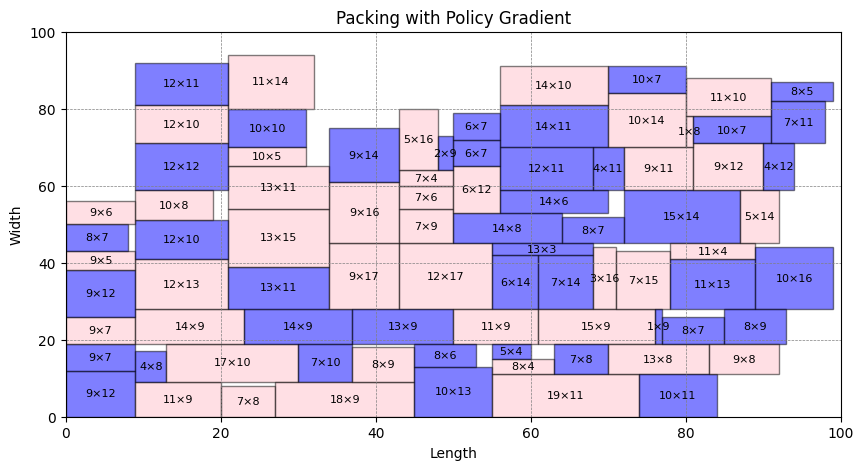

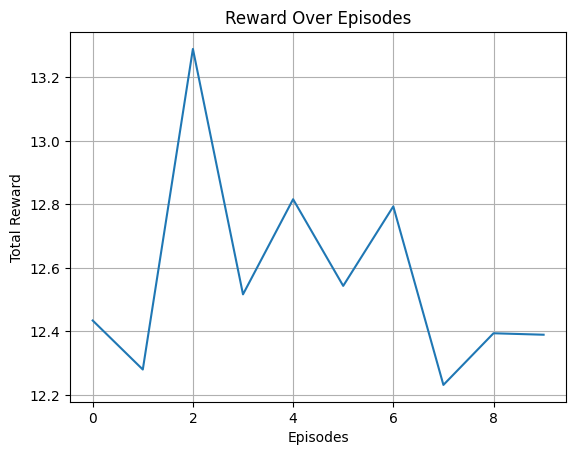

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def save_agent(agent, save_path):
    torch.save({
        'qtable': agent.q_table,
        'gamma': agent.gamma,
        'lr': agent.alpha
    }, save_path)


width = 100
length = 100
items = []
for _, row in data.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))

env = Packing(width, length, items)
agent = QLearning(num_items=len(items))
episodes = 10
rewards = []

best_rw = float('-inf')
best_frame = None
best_place = None

for episode in range(episodes):
    agent.epsilon = max(0.1, 1 - episode / (episodes * 0.9))  # Decrease epsilon gradually
    env.reset()
    state = agent.get_state(env)
    total_rw = 0

    while not env.is_done():
        action = agent.choose_action(state, env)
        if action is None:
            break

        success, reward = env.place(action)
        next_state = agent.get_state(env)

        agent.update_q_table(state, action, reward, next_state, env)
        state = next_state
        total_rw += reward

    if total_rw > best_rw:
        best_rw = total_rw
        best_frame = env.frame.clone()  # clone Tensor
        best_place = env.placed_items.copy()  # copy list

    rewards.append(total_rw)
    save_agent(agent, save_path='ql_train.pth')

if best_frame is not None:
    env.frame = best_frame
if best_place is not None:
    env.placed_items = best_place
env.render()

plt.plot(rewards)
plt.title('Reward Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.grid()
plt.show()


In [91]:
def load_agent(agent, model_path, weights_only=False):
    checkpoint = torch.load(model_path)
    agent.q_table = checkpoint['qtable']
    agent.gamma = checkpoint['gamma']
    agent.alpha = checkpoint['lr']


def predict_render(agent, env):
    env.reset()
    state = env.get_state()

    while not env.is_done():
        action = agent.choose_action(state, env)
        if action is None:
            break

        success, reward = env.place(action)

    env.render()

C:\Users\LUC\AppData\Local\Temp\ipykernel_24712\4246245408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


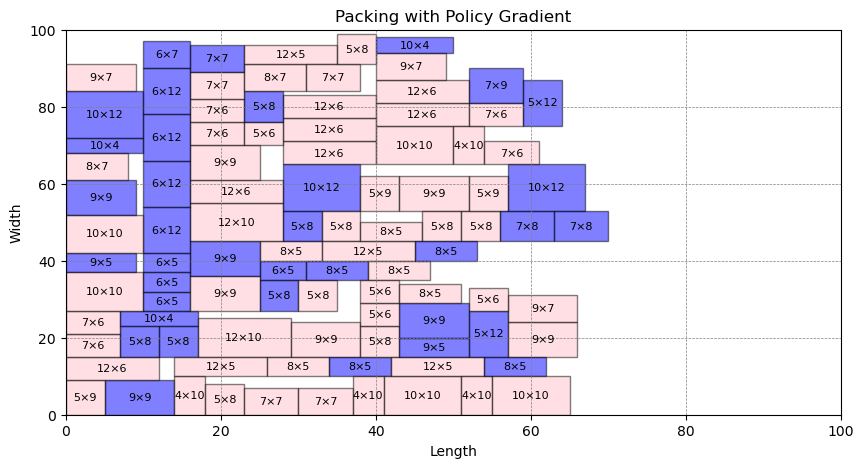

In [105]:
X = pd.read_csv('Luc_hienlanh_test.csv')
items = []
for _, row in X.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))
env = Packing(width=100, height=100, items=items)
agent = QLearning(num_items=len(items))
load_agent(agent, model_path='ql_train.pth', weights_only=False)
predict_render(agent, env)


## Policy Gradient algorithm

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, height, width, action_size, num_items, gamma=0.99, lr=1e-4):
        super().__init__()
        self.height = height
        self.width = width
        self.action_size = action_size
        self.num_items = num_items
        self.gamma = gamma
        self.lr = lr
        # frame network
        self.frame_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        ).to(device)

        # items network
        self.item_net = nn.Sequential(
            nn.Linear(num_items * 2, 128),
            nn.ReLU()
        ).to(device)

        # combined 2 features network
        self.combined_size = self._calc_combined_size()
        self.policy_head = nn.Sequential(
            nn.Linear(self.combined_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        ).to(device)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def _calc_combined_size(self):
        with torch.no_grad():
            dummy_frame = torch.zeros((1, 1, self.height, self.width), device=device)
            frame_out = self.frame_net(dummy_frame)
            frame_dim = frame_out.shape[1]

            dummy_items = torch.zeros((1, self.num_items * 2), device=device)
            item_out = self.item_net(dummy_items)
            item_dim = item_out.shape[1]

        return frame_dim + item_dim

    def forward(self, frame, items_tensor):
        """
        frame: (batch,1,H,W) trên GPU
        items_tensor: (batch, num_items*2) trên GPU
        return logits: (batch, action_size)
        """
        f_feat = self.frame_net(frame)
        i_feat = self.item_net(items_tensor)
        combined = torch.cat((f_feat, i_feat), dim=1)
        logits = self.policy_head(combined)
        return logits

    def select_action(self, state, valid_actions):
        frame, items = state
        frame = frame.unsqueeze(0).unsqueeze(0).float().to(device)     # (1,1,H,W)
        items = items.view(1, -1).float().to(device)                   # (1, N*2)

        logits = self.forward(frame, items).squeeze(0)                 # (action_size,)
        probs = torch.softmax(logits, dim=-1)

        # Mask
        mask = torch.zeros_like(probs)
        if valid_actions:
            mask[valid_actions] = 1.0
        else:
            mask[:] = 1.0

        masked_probs = probs * mask
        if masked_probs.sum() <= 1e-8:
            masked_probs = mask
        masked_probs = masked_probs / masked_probs.sum()

        dist = torch.distributions.Categorical(masked_probs)
        action_idx = dist.sample()
        log_prob = dist.log_prob(action_idx)
        return action_idx.item(), log_prob

    def update_policy(self, log_probs, rewards):
        # Tính discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)

        if returns.std() > 1e-8:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Policy loss
        policy_loss = []
        for lp, ret in zip(log_probs, returns):
            policy_loss.append(-lp * ret)
        policy_loss = torch.stack(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

    def train_one_episode(self, env):
        action_space = [(i, rot) for i in range(env.num_items) for rot in [False, True]]
        env.reset()

        frame_cpu, items_cpu = env.get_state()  # CPU
        done = False
        total_reward = 0

        log_probs = []
        rewards = []

        while not done:
            valid_actions = env.get_valid_actions(action_space)
            if not valid_actions:
                break

            action_idx, log_prob = self.select_action((frame_cpu, items_cpu), valid_actions)
            success, reward = env.place(action_space[action_idx])

            log_probs.append(log_prob)
            rewards.append(reward)
            total_reward += reward

            frame_cpu, items_cpu = env.get_state()  # CPU
            if env.is_done():
                done = True

        self.update_policy(log_probs, rewards)
        return total_reward

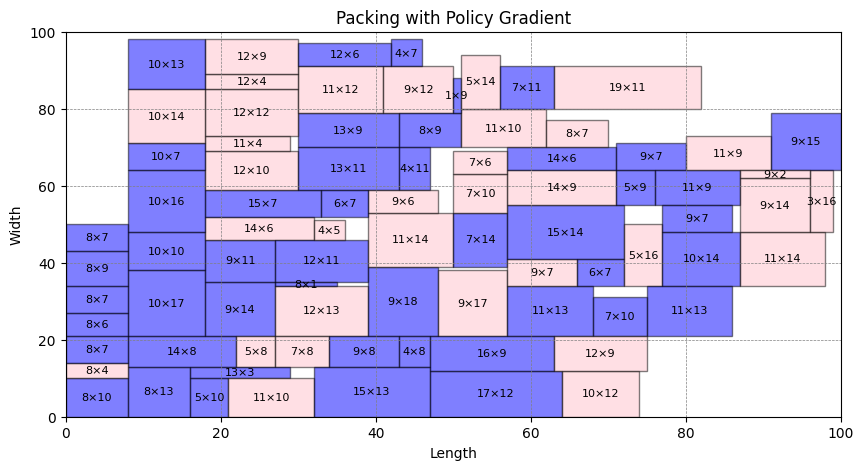

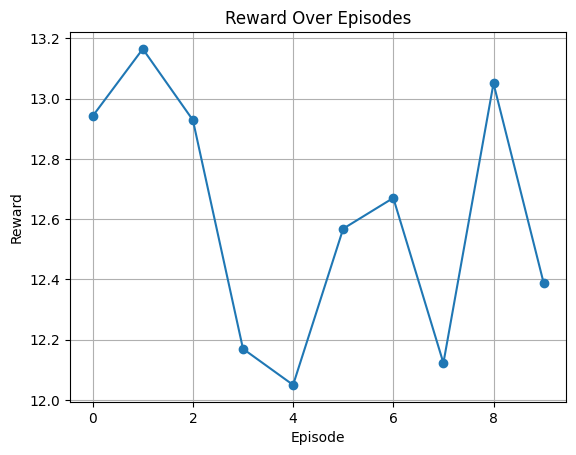

In [13]:

def save_agent(agent, save_path):
    torch.save({
        'policy_state_dict': agent.policy_head.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'gamma': agent.gamma,
        'lr': agent.lr
    }, save_path)
    
    
width = 100
height = 100
episodes = 10

items = []
for _, row in data.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))

env = Packing(width, height, items)

agent = PolicyNetwork(
    height=height,
    width=width,
    action_size=len(items)*2,
    num_items=len(items),
    gamma=0.99,
    lr=1e-4
)

rewards = []
best_rw = float('-inf')
best_frame = None
best_placed = None

for ep in range(episodes):
    total_reward = agent.train_one_episode(env)
    
    if total_reward > best_rw:
        best_rw = total_reward
        best_frame = env.frame.clone()       
        best_placed = env.placed_items.copy()

    rewards.append(total_reward)
    save_agent(agent, save_path='train_plc.pth')

if best_frame is not None:
    env.frame = best_frame
if best_placed is not None:
    env.placed_items = best_placed

env.render()

# Plot
plt.figure()
plt.plot(rewards, marker='o')
plt.title('Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

## Policy Test



In [112]:
def load_agent(agent, model_path):
    checkpoint = torch.load(model_path)
    agent.policy_head.load_state_dict(checkpoint['policy_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.gamma = checkpoint['gamma']
    agent.lr = checkpoint['lr']

def predict_render(agent, env):
    action_space = [(i, rotated) for i in range(env.num_items) for rotated in [True, False]]
    env.reset()
    frame, items = env.get_state()
    done = False

    while not done:
        valid_action = env.get_valid_actions(action_space)
        if not valid_action:
            break

        action_idx, log_prob = agent.select_action((frame, items), valid_action)
        success, reward = env.place(action_space[action_idx])
        frame, items = env.get_state()  
        if env.is_done():
            done = True

    env.render()

C:\Users\LUC\AppData\Local\Temp\ipykernel_24712\4264780659.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


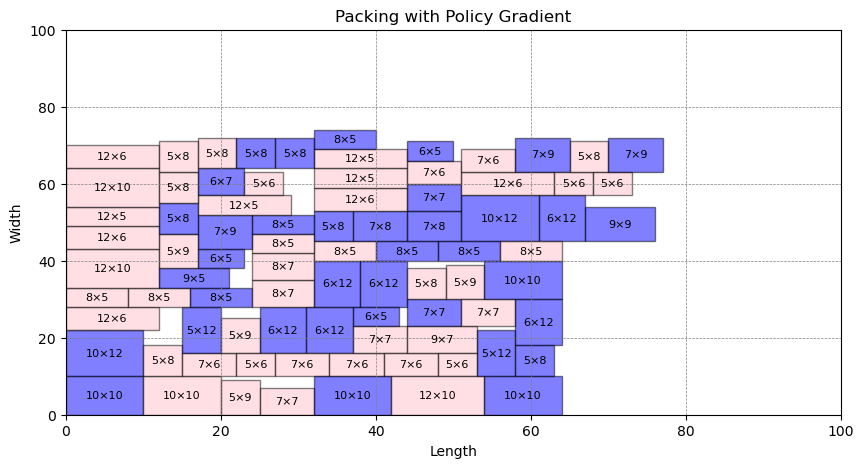

In [182]:
X = pd.read_csv('Luc_hienlanh_test.csv')
items = []
for _, row in X.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))
while len(items) < 82:
    items.append((0, 0))
if len(items) > 82:
    items = items[:82]
env = Packing(width=100, height=100, items=items)
agent = PolicyNetwork(
        height=100,
        width=100,
        action_size=len(items)*2,
        num_items=len(items),
        gamma=0.99,
        lr=1e-4
    )
load_agent(agent, model_path='train_plc.pth')
predict_render(agent, env)

## Advantage Actor-Critic algorithm




In [14]:
class A2CNetwork(nn.Module):
    def __init__(self, height, width, action_size, num_items, gamma=0.99, lr=1e-4):
        super().__init__()
        self.height = height
        self.width  = width
        self.action_size= action_size
        self.num_items= num_items
        self.gamma= gamma
        self.lr = lr

        self.frame_net = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten()
        ).to(device)

        self.item_net = nn.Sequential(
            nn.Linear(num_items*2,128),
            nn.ReLU()
        ).to(device)

        self.combined_size = self._calc_combined_size()

        self.actor = nn.Sequential(
            nn.Linear(self.combined_size,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,action_size)
        ).to(device)

        self.critic = nn.Sequential(
            nn.Linear(self.combined_size,128),
            nn.ReLU(),
            nn.Linear(128,1)
        ).to(device)

        self.optimizer = optim.Adam(
            list(self.frame_net.parameters())
            + list(self.item_net.parameters())
            + list(self.actor.parameters())
            + list(self.critic.parameters()),
            lr=self.lr
        )

    def _calc_combined_size(self):
        with torch.no_grad():
            dummy_frame = torch.zeros((1,1,self.height,self.width), device=device)
            out_frame = self.frame_net(dummy_frame)
            frame_dim = out_frame.shape[1]

            dummy_items = torch.zeros((1,self.num_items*2), device=device)
            out_items = self.item_net(dummy_items)
            item_dim = out_items.shape[1]
        return frame_dim + item_dim

    def forward(self, frame_4d, item_2d):
        feat_f = self.frame_net(frame_4d)
        feat_i = self.item_net(item_2d)
        combined = torch.cat((feat_f, feat_i), dim=1)
        logits = self.actor(combined)
        value = self.critic(combined)
        return logits, value

    def select_action(self, state, valid_idx):
        frame, remain = state
        # => frame_cpu shape(H,W)
        frame_4d= frame.unsqueeze(0).unsqueeze(0).float().to(device)
        # => (1,1,H,W)

        remain_np = remain.detach().cpu().numpy().reshape(1, -1) # => (1, N*2)
        remain_t = torch.from_numpy(remain_np).float().to(device)

        logits, val = self.forward(frame_4d, remain_t)
        logits = logits.squeeze(0)
        val = val.squeeze(0)

        probs = torch.softmax(logits, dim=-1)

        mask = torch.zeros_like(probs)
        if valid_idx:
            mask[valid_idx]=1.0
        else:
            mask[:] = 1.0

        masked_probs = probs*mask
        if masked_probs.sum() < 1e-8:
            masked_probs = mask
        masked_probs = masked_probs / masked_probs.sum()

        dist = torch.distributions.Categorical(masked_probs)
        action_idx = dist.sample()
        log_prob = dist.log_prob(action_idx)
        return action_idx.item(), log_prob, val

    def update_ac(self, log_probs, values, rewards, next_val, done):
        log_probs = torch.stack(log_probs)
        values = torch.stack(values)

        returns = []
        G = 0 if done else next_val.item()
        for r in reversed(rewards):
            G = r + self.gamma*G
            returns.insert(0,G)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)

        advantage = returns - values.squeeze(-1)
        actor_loss = -(log_probs* advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_one_episode(self, env, batch_size=32):
        action_space = [(i,rot) for i in range(env.num_items) for rot in [False,True]]
        env.reset()
        done = False
        frame, remain = env.get_state()
        total_reward = 0
        transitions = []
        sum_loss = 0

        while not done:
            valid_idx = env.get_valid_actions(action_space)
            if not valid_idx:
                break

            a_idx, log_p, val = self.select_action((frame, remain), valid_idx)
            action = action_space[a_idx]
            success, reward = env.place(action)
            next_frame, next_remain = env.get_state()

            transitions.append((log_p, val, reward))
            frame, remain= next_frame, next_remain
            total_reward += reward
            done = env.is_done()

            if len(transitions) == batch_size or done:
                if done:
                    next_val = torch.tensor(0.0, device=device)
                else:
                    nf_4d = next_frame.unsqueeze(0).unsqueeze(0).float().to(device)
                    nr_np = next_remain.detach().cpu().numpy().reshape(1,-1)
                    nr_t = torch.from_numpy(nr_np).float().to(device)

                    with torch.no_grad():
                        logits2, val2 = self.forward(nf_4d,nr_t)
                        next_val = val2.squeeze(0)

                lgs, vals, rws = zip(*transitions)
                sum_loss += self.update_ac(lgs, vals, rws, next_val, done)
                transitions = []
        return total_reward, sum_loss

Episode 1/10, Reward=12.69, Loss=39.1167
Episode 2/10, Reward=12.47, Loss=32.9229
Episode 3/10, Reward=12.76, Loss=34.1454
Episode 4/10, Reward=13.12, Loss=30.8516
Episode 5/10, Reward=12.58, Loss=27.5352
Episode 6/10, Reward=12.82, Loss=28.0695
Episode 7/10, Reward=11.72, Loss=27.6463
Episode 8/10, Reward=12.47, Loss=25.6800
Episode 9/10, Reward=12.52, Loss=21.6109
Episode 10/10, Reward=13.10, Loss=21.1091
82


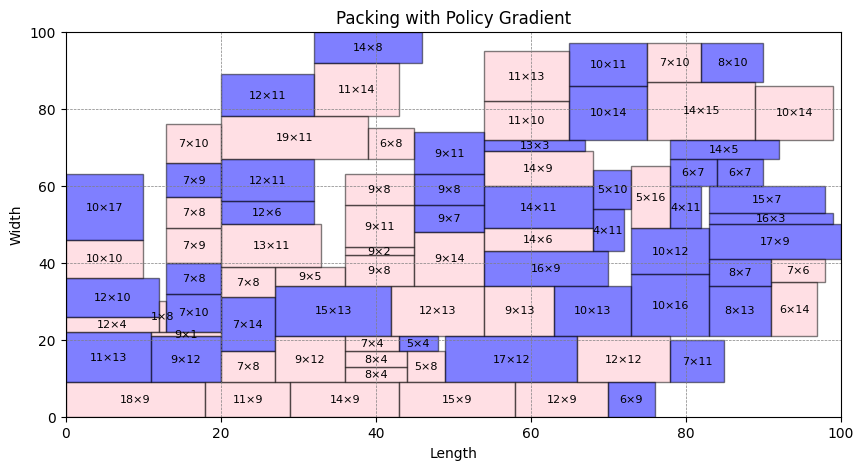

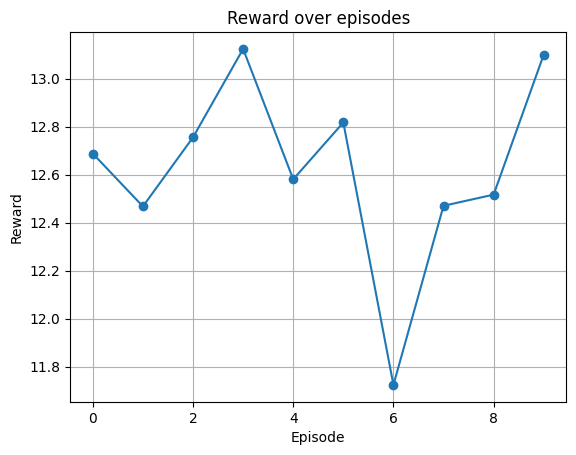

In [22]:

def save_agent(agent, save_path):
    torch.save({
        'actor_net_state_dict': agent.actor.state_dict(),
        'critic_net_state_dict': agent.critic.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'gamma': agent.gamma

    }, save_path)
    
    
width = 100
height = 100
episodes = 10

# Đọc dữ liệu từ CSV
data = pd.read_csv('Minh_cute_train.csv')
items = []
for _, row in data.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))

# Tạo env
env = Packing(width, height, items)

# Tạo agent => GPU nếu có
agent = A2CNetwork(
    height=height,
    width=width,
    action_size=len(items) * 2,
    num_items=len(items),
    gamma=0.99,
    lr=1e-4
).to(device)

rewards = []
best_rw = float('-inf')
best_frame = None
best_placed = None

for ep in range(episodes):
    total_reward, sum_loss = agent.train_one_episode(env, batch_size=32)
    if total_reward > best_rw:
        best_rw = total_reward
        best_frame = env.frame.clone()
        best_placed = env.placed_items.copy()

    rewards.append(total_reward)
    print(f"Episode {ep + 1}/{episodes}, Reward={total_reward:.2f}, Loss={sum_loss:.4f}")
    save_agent(agent, save_path='a2c_train.pth')

# Khôi phục best
if best_frame is not None:
    env.frame = best_frame
if best_placed is not None:
    env.placed_items = best_placed
num = len(env.placed_items)
print(num)

env.render()

# plot
plt.figure()
plt.plot(rewards, marker='o')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward over episodes")
plt.grid()
plt.show()

In [185]:
def load_agent(agent, model_path):
    checkpoint = torch.load(model_path)
    agent.actor.load_state_dict(checkpoint['actor_net_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_net_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.gamma = checkpoint['gamma']

def predict_render(agent, env):
    action_space = [(i, rotated) for i in range(env.num_items) for rotated in [True, False]]
    env.reset()
    frame, items = env.get_state()
    done = False

    while not done:
        valid_action = env.get_valid_actions(action_space)
        if not valid_action:
            break

        action_idx, log_prob, val = agent.select_action((frame, items), valid_action)
        success, reward = env.place(action_space[action_idx])
        frame, items = env.get_state()
        if env.is_done():
            done = True

    env.render()

C:\Users\LUC\AppData\Local\Temp\ipykernel_24712\1485446075.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


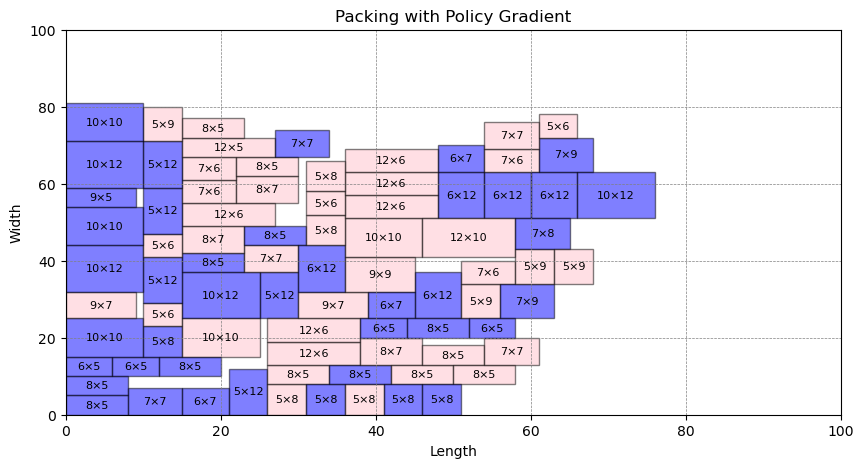

In [293]:
X = pd.read_csv('Luc_hienlanh_test.csv')
items = []
for _, row in X.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))
while len(items) < 82:
    items.append((0, 0))
if len(items) > 82:
    items = items[:82]
env = Packing(width=100, height=100, items=items)
agent = A2CNetwork(
        height=100,
        width=100,
        action_size=len(items)*2,
        num_items=len(items),
        gamma=0.99,
        lr=1e-4
    )
load_agent(agent, model_path='a2c_train.pth')
predict_render(agent, env)

## Promoxial Policy Optimization

## PPO tách file và hiệu chỉnh một ít về env, số ep, data 

In [75]:
import torch 
from PPO import PPOAgent
def load_agent(agent, model_path): 
    checkpoint = torch.load(model_path)
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def predict_and_render(agent, env): 
    action_space = [(i, rotated) for i in range(env.num_items) for rotated in [True, False]]
    env.reset()
    frame, items = env.get_state()
    done = False

    while not done: 
        valid_action = env.get_valid_actions(action_space)
        if not valid_action: 
            break

        action_idx, log_prob = agent.select_action((frame, items), valid_action)
        success, reward = env.place(action_space[action_idx])
        frame, items = env.get_state()
        if env.is_done():
            done = True

    env.render()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_79492\913269140.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


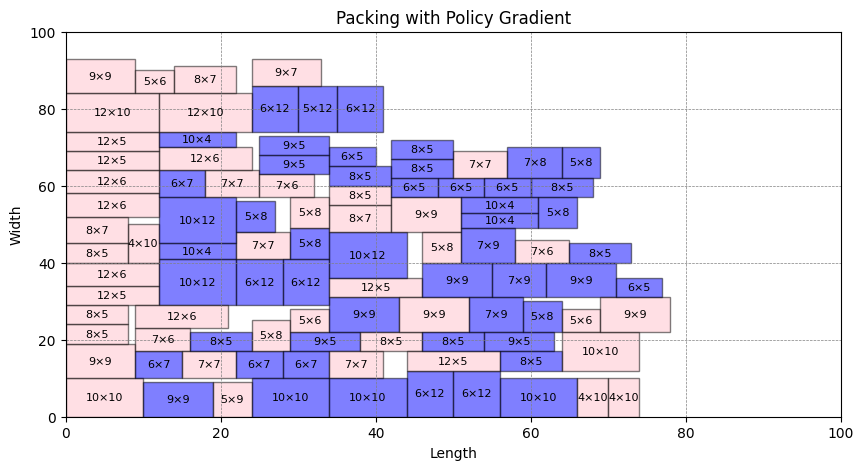

In [79]:
X = pd.read_csv('Luchienlanhtest.csv')
items = []
for _, row in X.iterrows():
    items.extend([(row['Height'], row['Width'])] * int(row['Quantity']))
while len(items) < 115:
    items.append((0, 0))
if len(items) > 115:
    items = items[:82]
env = Packing(width=100, height=100, items=items)
agent = PPOAgent(
        frame_shape = (100, 100),
        action_size=len(items)*2,
        num_items=len(items),
        gamma=0.99,
        lr=1e-4,
        device= 'cpu'
    )
load_agent(agent, model_path='ppo_model.pth')
predict_and_render(agent, env)